
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values
        
        


<B>INCLUDED IN THIS FILE:</B>


1) Create an MDP for Numerical Tic-Tac-Toe game. The basic framework for this is:

* Initialise the state

* Define the action space for each state. (Be careful in defining actions. The actions are not the same for each state)

* Define the winning states: the sum of three numbers in a row, column or diagonal is 15.

* Define the terminal states (win,tie,loss)

* Build the reward structure as below:

        * +10 if the agent wins (makes 15 points first)

        * -10 if the environment wins

        * 0 if the game ends in a draw (no one is able to make 15 and the board is filled up)

        * -1 for each move agent takes

* Define a step function which takes in an input of the agent’s action and state; and outputs the next state and reward. (Make sure you incorporate environment’s move in the next state).

* For your reference: TCGame_Env.py file is provided with a basic structure of the code. The functions (and the comments) will provide an intuition of how the MDP would be formulated. Codes of a few functions are also provided to give you more sense on how to proceed with the MDP. Note: Using this framework is not compulsory, you can create your own framework and functions as well.

2) Build an agent that learns the game by Q-Learning. You can choose the hyperparameters (epsilon (decay rate), learning-rate, discount factor) of your choice. For that, you can train the model iteratively to obtain a good combination of hyperparameters. You won’t be evaluated on your choice of the hyperparameters. You need to submit only the final model. 

* While updating the Q-values, if the next state is a terminal state, then the Q-values from that state are 0. (No action is possible from that state)

* For a 64-bit system with 8GB RAM, it takes ~30 minutes to run 5Mn episodes.

3) Q-values convergence- check whether Q-values learnt by the agent have converged or not. Sample 4 state-action pairs and plot it with the number of episodes to understand the convergence.

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file

from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

# Creating environment variable for TicTacToe() function
env = TicTacToe()

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary.

def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy_policy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001
    
    eps = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > eps:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   
    else:
        p_action = [i for i in env.action_space(state)[0]]        
        action = p_action[np.random.choice(range(len(p_action)))]
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked

def initialise_tracking_states():
    Sample_Qvalues = [('1-x-x-3-x-x-x-x-x',(6,7)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-2-x-x-3-x-x-x-x',(0,1)),('x-5-x-x-x-x-5-7-x',(8,2))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

#### Define hyperparameters  ---write your code here

In [10]:
EPISODES = 50000
LR = 0.01               # learning rate
threshold = 200         # no of episodes after which states_tracked will be saved
policy_threshold = 300  # no of episodes after which Q dictionary will be saved
GAMMA = 0.9             # discount factor
decay_rate = 0.001      # epsilon decay rate

In [11]:
initialise_tracking_states()

### Q-update loop ---write your code here

In [12]:
import time 
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy_policy(curr_state, episode)   # applying epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # getting rewar
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)

        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        
     #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')
#         print(episode) 

    if ((episode+1)% policy_threshold) == 0:  #every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy_Q_dict')  
        

elapsed_time = time.time() - start_time
print('Time taken for the training and learning : ' + str(elapsed_time))
save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Policy_Q_dict')

Time taken for the training and learning : 96.65056824684143


#### Check the Q-dictionary

In [13]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.0067156954237086,
              (0, 3): -1.0067276562543779,
              (0, 5): -1.0067333856039398,
              (0, 7): -1.0067248870073584,
              (0, 9): -1.0067241746009763,
              (1, 1): -1.0067236396077701,
              (1, 3): -1.00673018924541,
              (1, 5): -1.0065608321663253,
              (1, 7): -1.0067126631193593,
              (1, 9): -1.0067183696916946,
              (2, 1): -1.0067237760983336,
              (2, 3): -1.0067114976528233,
              (2, 5): -1.0067208987519314,
              (2, 7): -1.00671457675363,
              (2, 9): -1.0067332789827956,
              (3, 1): -1.0067184259229593,
              (3, 3): -1.0067192908843932,
              (3, 5): -1.0067305983861146,
              (3, 7): -1.0067107463676006,
              (3, 9): -1.0067234585163036,
              (4, 1): -1.0067187966462805,
              (4, 3): -1.0067254800463308,
              (4, 5

In [14]:
len(Q_dict)

130635

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(*args, **kw)>

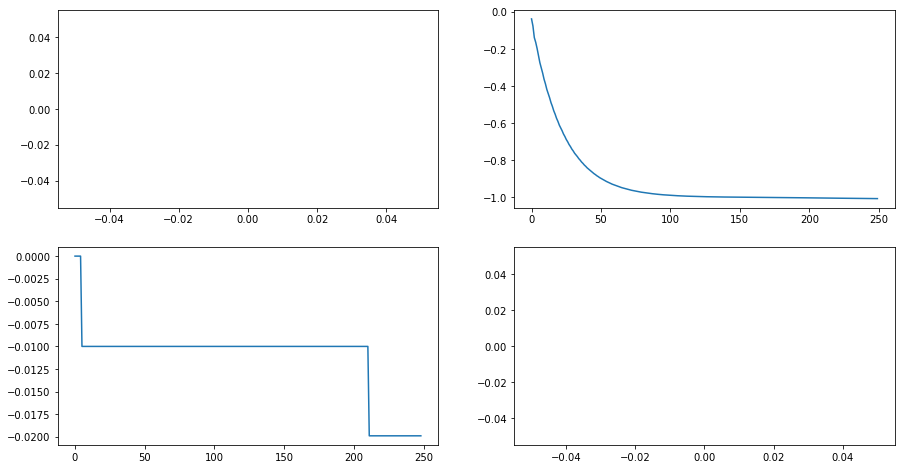

In [15]:
# Write the code for plotting the graphs for state-action pairs tracked

plt.figure(0, figsize=(15,8))

x_axis = np.asarray(range(0, len(States_track['1-x-x-3-x-x-x-x-x'][(6,7)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['1-x-x-3-x-x-x-x-x'][(6,7)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-2-x-x-3-x-x-x-x'][(0,1)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-2-x-x-3-x-x-x-x'][(0,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-5-x-x-x-x-5-7-x'][(8,2)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-5-x-x-x-x-5-7-x'][(8,2)]))
plt.show

### Epsilon - decay check

In [16]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

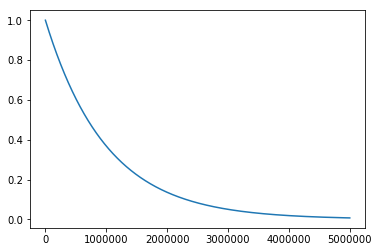

In [17]:
plt.plot(time, epsilon)
plt.show()